## 使用自編碼器（Autoencoder, AE）去除圖片雜訊
自編碼器是一種實現編碼和解馬的神經網路，屬於一種資料壓縮的演算法。可以將原始資料透過編碼器（Encoder）進行壓縮，再使用解碼器（Decoder）還原成原始資料。
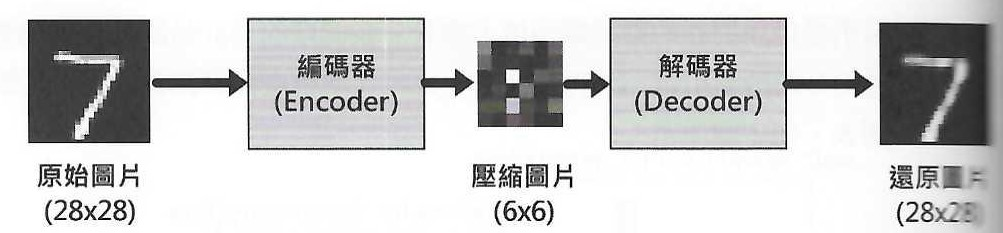

自編碼器有以下特點：


1.   只適用特定資料：自編碼器只適用與訓練資料集相似的資料壓縮
2.   資料損失：自編碼器壓縮和還原會有資料損失，還原資料不會和原始資料完全相同。
3.   非監督式學習：自編碼器是自行從資料學習。不需要標籤資料。也稱為自我監督式學習，因為訓練資料集就是和自己比較損失來進行學習。

以下我們使用自編碼器，並且利用 Keras 的 Functional API(有別於Sequential) 來實作去除圖片中雜訊



## 函式庫與資料集載入

In [ ]:
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

In [ ]:
# 指定亂數種子
seed = 7
np.random.seed(seed)
# 載入資料集
(X_train, _), (X_test, _) = mnist.load_data()
# 轉換成 4D 張量
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype("float32")
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype("float32")
# 因為是固定範圍, 所以執行正規化, 從 0-255 至 0-1
X_train = X_train / 255
X_test = X_test / 255

### 定義 autoencoder 模型

In [ ]:
input_img = Input(shape=(28,28,1))
x = Conv2D(16, (3,3), activation="relu", padding="same")(input_img)
x = MaxPooling2D((2,2), padding="same")(x)
x = Conv2D(8, (3,3), activation="relu", padding="same")(x)
x = MaxPooling2D((2,2), padding="same")(x)
x = Conv2D(8, (3,3), activation="relu", padding="same")(x)
encoded = MaxPooling2D((2,2), padding="same")(x)

x = Conv2D(8, (3,3), activation="relu", padding="same")(encoded)
x = UpSampling2D((2,2))(x)
x = Conv2D(8, (3,3), activation="relu", padding="same")(x)
x = UpSampling2D((2,2))(x)
x = Conv2D(16, (3,3), activation="relu")(x)
x = UpSampling2D((2,2))(x)
decoded = Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

autoencoder = Model(input_img, decoded)
autoencoder.summary()    # 顯示模型摘要資訊

### 定義 encoder 模型

In [ ]:
# 定義 encoder 模型
encoder = Model(input_img, encoded)
encoder.summary()   # 顯示模型摘要資訊

### 定義 decoder 模型

In [ ]:
decoder_input = Input(shape=(4,4,8))
decoder_layer = autoencoder.layers[-7](decoder_input)
decoder_layer = autoencoder.layers[-6](decoder_layer)
decoder_layer = autoencoder.layers[-5](decoder_layer)
decoder_layer = autoencoder.layers[-4](decoder_layer)
decoder_layer = autoencoder.layers[-3](decoder_layer)
decoder_layer = autoencoder.layers[-2](decoder_layer)
decoder_layer = autoencoder.layers[-1](decoder_layer)
decoder = Model(decoder_input, decoder_layer)
decoder.summary()   # 顯示模型摘要資訊

In [ ]:
# 編譯模型
autoencoder.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
# 訓練模型
autoencoder.fit(X_train, X_train, validation_data=(X_test, X_test), epochs=10, batch_size=128, shuffle=True, verbose=2)

In [ ]:
# 壓縮圖片
encoded_imgs = encoder.predict(X_test)

In [ ]:
# 解壓縮圖片
decoded_imgs = decoder.predict(encoded_imgs)

In [ ]:
# 顯示原始, 壓縮和還原圖片
import matplotlib.pyplot as plt

n = 10  # 顯示幾個數字
plt.figure(figsize=(20, 8))
for i in range(n):
    # 原始圖片
    ax = plt.subplot(3, n, i + 1)
    ax.imshow(X_test[i].reshape(28, 28), cmap="gray")
    ax.axis("off")
    # 壓縮圖片
    ax = plt.subplot(3, n, i + 1 + n)
    ax.imshow(encoded_imgs[i].reshape(4, 4*8).T, cmap="gray")
    ax.axis("off")
    # 還原圖片
    ax = plt.subplot(3, n, i + 1 + 2*n)
    ax.imshow(decoded_imgs[i].reshape(28, 28), cmap="gray")
    ax.axis("off")
plt.show()

### 產生帶有雜訊的圖片 並用上述CNN自編碼器進行訓練

In [ ]:
# 替圖片製造雜訊
nf = 0.5
size_train = X_train.shape
X_train_noisy = X_train+nf*np.random.normal(loc=0.0, scale=1.0,size=size_train)
X_train_noisy = np.clip(X_train_noisy, 0., 1.)
size_test = X_test.shape
X_test_noisy = X_test+nf*np.random.normal(loc=0.0, scale=1.0,size=size_test)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

In [ ]:
# 訓練模型
autoencoder.fit(X_train_noisy, X_train, validation_data=(X_test_noisy, X_test), 
                epochs=10, batch_size=128, shuffle=True, verbose=2)

In [ ]:
# 壓縮圖片
encoded_imgs = encoder.predict(X_test_noisy)
# 解壓縮圖片
decoded_imgs = decoder.predict(encoded_imgs)

In [ ]:
# 顯示雜訊圖片, 壓縮圖片和還原圖片
import matplotlib.pyplot as plt

n = 10  # 顯示幾個數字
plt.figure(figsize=(20, 8))
for i in range(n):
    # 雜訊圖片
    ax = plt.subplot(3, n, i + 1)
    ax.imshow(X_test_noisy[i].reshape(28, 28), cmap="gray")
    ax.axis("off")
    # 壓縮圖片
    ax = plt.subplot(3, n, i + 1 + n)
    ax.imshow(encoded_imgs[i].reshape(4, 4*8).T, cmap="gray")
    ax.axis("off")
    # 還原圖片
    ax = plt.subplot(3, n, i + 1 + 2*n)
    ax.imshow(decoded_imgs[i].reshape(28, 28), cmap="gray")
    ax.axis("off")
plt.show()